In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys

project_path = '/content/drive/MyDrive/mlypracticum'

if project_path not in sys.path:
    sys.path.append(project_path)

import torch
import torch.nn as nn
import torch.optim as optim

# Этап 1. Загрузка и предобработка данных

In [5]:
import zipfile

zip_path = project_path + '/data/ogyeiv2.zip'

extract_path = project_path + '/data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Датасет распакован!")

Датасет распакован!


In [6]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandomHorizontalFlip, RandomRotation, ColorJitter

# ImageNet stats
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
im_size = 224

batch_size = 64

train_path = project_path + "/data/ogyeiv2/train"
test_path = project_path + "/data/ogyeiv2/test"

train_transform = Compose([
    Resize((im_size, im_size)),
    RandomHorizontalFlip(p=0.5),      # Отражаем половину картинок
    RandomRotation(degrees=15),       # Немного вращаем
    ColorJitter(brightness=0.1),
    ToTensor(),
    Normalize(mean=mean, std=std)
])

test_transform = Compose([
    Resize((im_size, im_size)),
    ToTensor(),
    Normalize(mean=mean, std=std)
])

class PillsDataset(ImageFolder):
     def __init__(self, root, transform=None):
        super().__init__(root=root, transform=transform)


def load_data(train_path=train_path, test_path=test_path, batch_size=batch_size):

    train_dataset = PillsDataset(train_path, transform=train_transform)
    test_dataset = PillsDataset(test_path, transform=test_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, train_dataset, test_dataset

In [7]:
train_loader, val_loader, train_dataset, val_dataset = load_data()

print("Количество классов:", len(train_dataset.classes))
print("Количество изображений train:", len(train_dataset))
print("Количество изображений test:", len(val_dataset))

Количество классов: 84
Количество изображений train: 2352
Количество изображений test: 504


# Этап 2. Объявление модели

In [8]:
from torchvision import models

def get_pills_classifier(num_classes):
    # современный способ загрузки весов
    weights = models.ResNet18_Weights.DEFAULT
    classifier = models.resnet18(weights=weights)

    # Замораживаем все слои
    for param in classifier.parameters():
        param.requires_grad = False

    # Заменяем финальный полносвязный слой
    classifier.fc = nn.Linear(classifier.fc.in_features, num_classes)

    return classifier

In [9]:
model = get_pills_classifier(len(train_dataset.classes))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 197MB/s]


# Этап 3. Обучение или дообучение

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
# Оптимизируем только размороженные параметры
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
EPOCHS = 10
best_vloss = 1e5

device

device(type='cuda')

In [12]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()

    total_loss = 0.
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_loss = total_loss / len(train_loader)
    avg_acc = 100. * correct / total

    return avg_loss, avg_acc

In [13]:
train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(EPOCHS):
    # Обучение
    avg_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(avg_loss)
    train_accs.append(train_acc)

    # Валидация
    model.eval()
    running_vloss = 0.0
    v_correct = 0
    v_total = 0

    with torch.no_grad():
        for vinputs, vlabels in val_loader:
            vinputs, vlabels = vinputs.to(device), vlabels.to(device)

            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss.item()

            # Считаем точность на валидации
            _, v_predicted = voutputs.max(1)
            v_total += vlabels.size(0)
            v_correct += v_predicted.eq(vlabels).sum().item()

    avg_vloss = running_vloss / len(val_loader)
    val_accuracy = 100. * v_correct / v_total

    val_losses.append(avg_vloss)
    val_accs.append(val_accuracy)

    # Сохранение лучшей модели
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        torch.save(model.state_dict(), project_path + f'/model/pills_classifier_model_{epoch+1}.pt')

    print(f'Эпоха [{epoch+1}/{EPOCHS}]')
    print(f'Train Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Val Loss:   {avg_vloss:.4f} | Val Acc:   {val_accuracy:.2f}%')
    print('-' * 30)

Эпоха [1/10]
Train Loss: 4.4309 | Train Acc: 3.57%
Val Loss:   3.9685 | Val Acc:   11.11%
------------------------------
Эпоха [2/10]
Train Loss: 3.9142 | Train Acc: 12.80%
Val Loss:   3.4314 | Val Acc:   24.40%
------------------------------
Эпоха [3/10]
Train Loss: 3.5444 | Train Acc: 23.68%
Val Loss:   3.0924 | Val Acc:   30.75%
------------------------------
Эпоха [4/10]
Train Loss: 3.2420 | Train Acc: 30.61%
Val Loss:   2.8252 | Val Acc:   35.52%
------------------------------
Эпоха [5/10]
Train Loss: 3.0112 | Train Acc: 34.57%
Val Loss:   2.6081 | Val Acc:   41.67%
------------------------------
Эпоха [6/10]
Train Loss: 2.8010 | Train Acc: 40.14%
Val Loss:   2.4158 | Val Acc:   43.45%
------------------------------
Эпоха [7/10]
Train Loss: 2.6342 | Train Acc: 45.45%
Val Loss:   2.2984 | Val Acc:   45.44%
------------------------------
Эпоха [8/10]
Train Loss: 2.4854 | Train Acc: 46.98%
Val Loss:   2.1372 | Val Acc:   47.62%
------------------------------
Эпоха [9/10]
Train Loss: 

In [14]:
# Размораживаем последний блок (layer4) и саму голову (fc)
# (fc и так разморожена, но layer4 даст модели "понимать" специфику таблеток)
for param in model.layer4.parameters():
    param.requires_grad = True

In [15]:
# используем меньший LR, чтобы не "взорвать" уже обученные веса ImageNet
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

# 3. Добавляем еще эпох
FINE_TUNE_EPOCHS = 10

print("Начинаем Fine-tuning...")

for epoch in range(FINE_TUNE_EPOCHS):
    avg_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)

    # Валидация (копируем логику из предыдущего цикла)
    model.eval()
    running_vloss = 0.0
    v_correct = 0
    v_total = 0
    with torch.no_grad():
        for vinputs, vlabels in val_loader:
            vinputs, vlabels = vinputs.to(device), vlabels.to(device)
            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss.item()
            _, v_predicted = voutputs.max(1)
            v_total += vlabels.size(0)
            v_correct += v_predicted.eq(vlabels).sum().item()

    val_accuracy = 100. * v_correct / v_total
    avg_vloss = running_vloss / len(val_loader)

    # Сохраняем, если результат стал еще лучше
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        torch.save(model.state_dict(), project_path + f'/model/pills_model_finetuned.pt')

    print(f'Fine-tune Epoch [{epoch+1}/{FINE_TUNE_EPOCHS}] Loss: {avg_loss:.4f} | Val Acc: {val_accuracy:.2f}%')

Начинаем Fine-tuning...
Fine-tune Epoch [1/10] Loss: 1.3992 | Val Acc: 76.79%
Fine-tune Epoch [2/10] Loss: 0.8373 | Val Acc: 85.12%
Fine-tune Epoch [3/10] Loss: 0.6127 | Val Acc: 90.08%
Fine-tune Epoch [4/10] Loss: 0.4629 | Val Acc: 91.67%
Fine-tune Epoch [5/10] Loss: 0.3613 | Val Acc: 92.66%
Fine-tune Epoch [6/10] Loss: 0.3017 | Val Acc: 95.24%
Fine-tune Epoch [7/10] Loss: 0.2465 | Val Acc: 94.84%
Fine-tune Epoch [8/10] Loss: 0.1999 | Val Acc: 95.04%
Fine-tune Epoch [9/10] Loss: 0.1743 | Val Acc: 95.83%
Fine-tune Epoch [10/10] Loss: 0.1399 | Val Acc: 95.44%


# Этап 4. Оценка качества

In [ ]:
# если нужна новая сессия работы
# model = get_pills_classifier(len(train_dataset.classes))
# model.load_state_dict(torch.load(project_path + f'/model/pills_model_finetuned.pt'))
# model = model.to(device)

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def final_evaluation(model, test_loader, device, classes):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # 1. Основные метрики: Precision, Recall, F1
    print("\n" + "="*60)
    print("ОТЧЕТ ПО КЛАССИФИКАЦИИ (Precision, Recall, F1)")
    print("="*60)
    print(classification_report(y_true, y_pred, target_names=classes))

    # 2. Accuracy для каждого класса отдельно
    print("\n" + "="*60)
    print("ACCURACY ДЛЯ КАЖДОГО КЛАССА")
    print("="*60)
    cm = confusion_matrix(y_true, y_pred)
    # Accuracy для класса = (верные предсказания класса) / (всего примеров этого класса)
    cls_accuracy = cm.diagonal() / cm.sum(axis=1)

    for name, acc in zip(classes, cls_accuracy):
        print(f"Класс {name:20} | Accuracy: {acc:.2%}")

    # Общая точность (проверка)
    overall_acc = accuracy_score(y_true, y_pred)
    print(f"\nОБЩАЯ ACCURACY КЛАССИФИКАТОРА: {overall_acc:.2%}")
    print("="*60)

final_evaluation(model, val_loader, device, train_dataset.classes)


ОТЧЕТ ПО КЛАССИФИКАЦИИ (Precision, Recall, F1)
                                  precision    recall  f1-score   support

                 acc_long_600_mg       1.00      1.00      1.00         6
               advil_ultra_forte       1.00      1.00      1.00         6
                   akineton_2_mg       1.00      0.50      0.67         6
      algoflex_forte_dolo_400_mg       1.00      1.00      1.00         6
           algoflex_rapid_400_mg       1.00      1.00      1.00         6
                algopyrin_500_mg       1.00      1.00      1.00         6
             ambroxol_egis_30_mg       0.83      0.83      0.83         6
                  apranax_550_mg       1.00      1.00      1.00         6
            aspirin_ultra_500_mg       0.86      1.00      0.92         6
                    atoris_20_mg       1.00      1.00      1.00         6
         atorvastatin_teva_20_mg       0.75      1.00      0.86         6
                   betaloc_50_mg       1.00      1.00      1.00

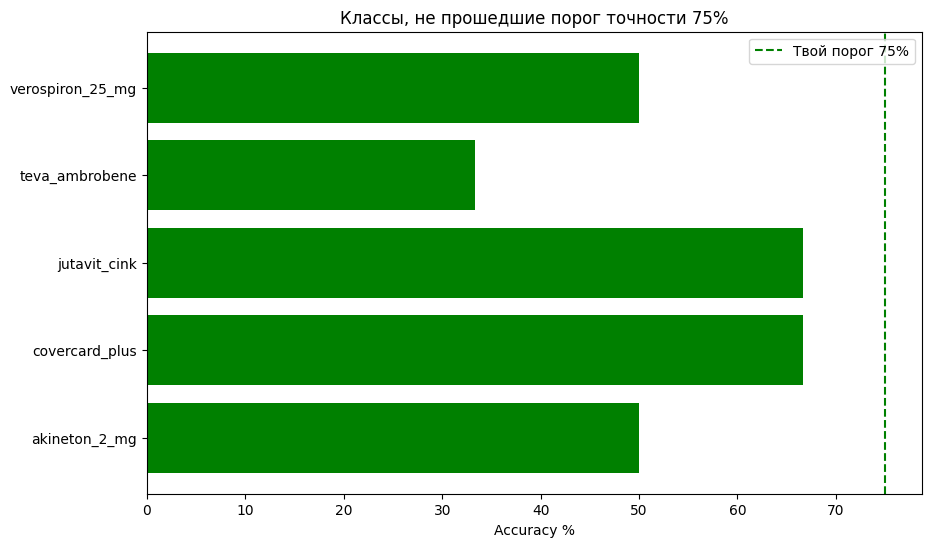

In [19]:
import matplotlib.pyplot as plt

# Данные из твоего отчета (пример для топ-10 и проблемных)
problem_classes = ['akineton_2_mg', 'covercard_plus', 'jutavit_cink', 'teva_ambrobene', 'verospiron_25_mg']
problem_accs = [50.0, 66.67, 66.67, 33.33, 50.0]

plt.figure(figsize=(10, 6))
colors = ['green' if x < 70 else 'skyblue' for x in problem_accs]
plt.barh(problem_classes, problem_accs, color=colors)
plt.axvline(x=75, color='green', linestyle='--', label='Твой порог 75%')
plt.title('Классы, не прошедшие порог точности 75%')
plt.xlabel('Accuracy %')
plt.legend()
plt.show()

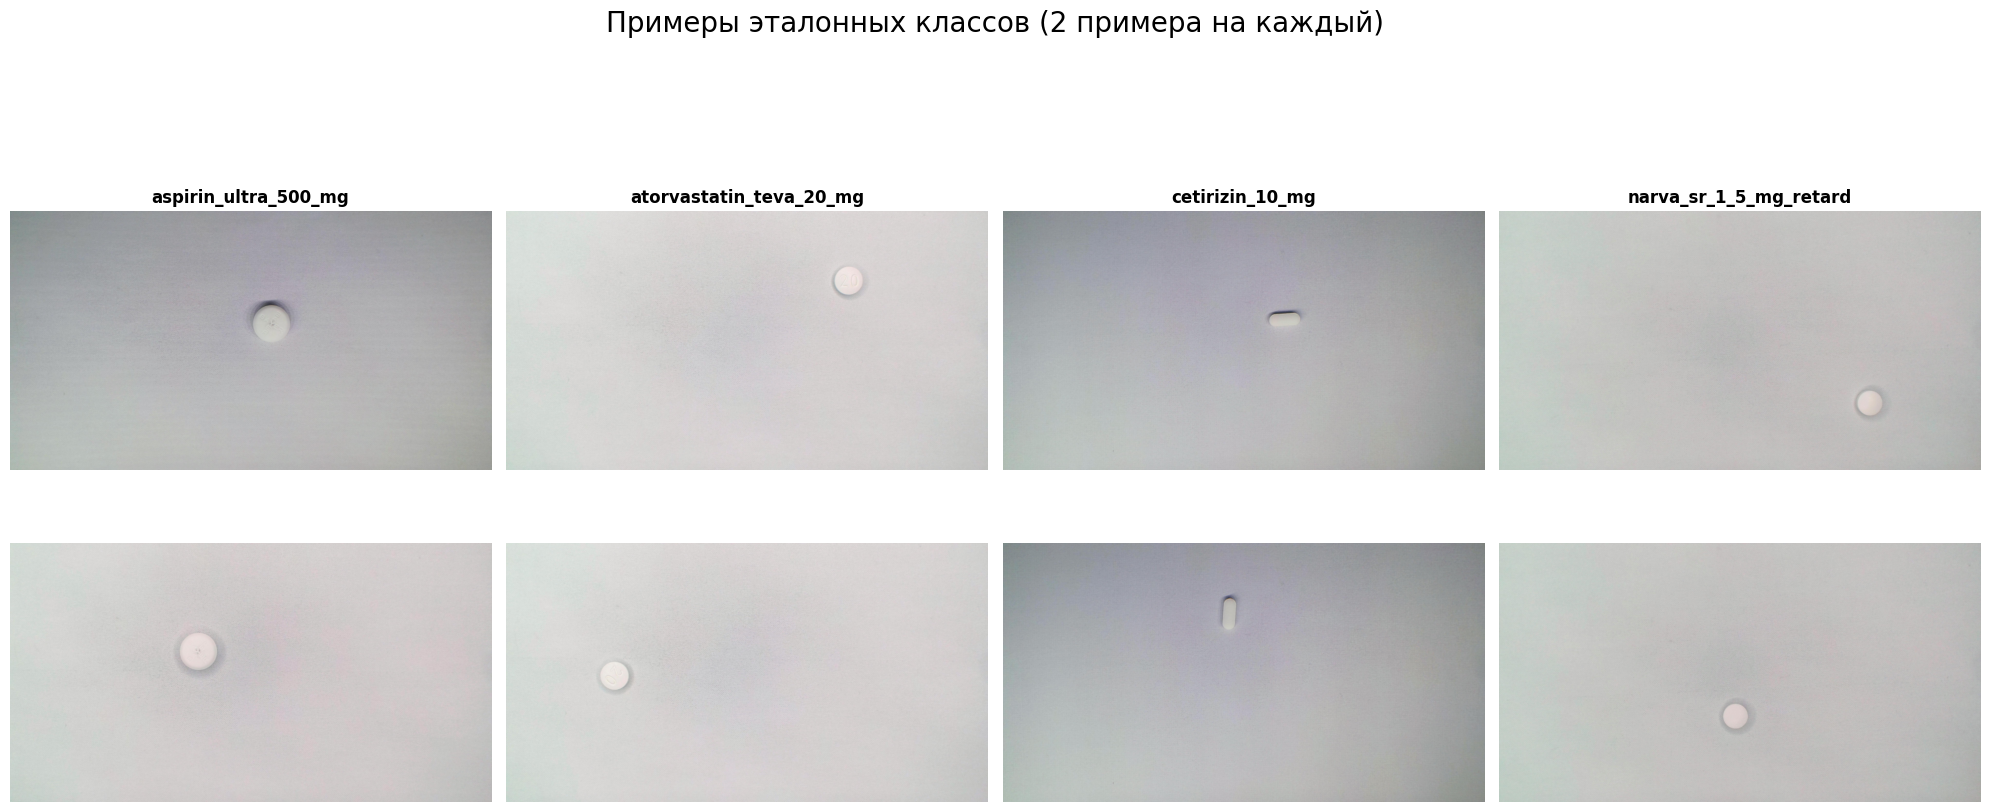

In [25]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import random

def show_meds_grid(base_path, selected_classes):
    fig, axes = plt.subplots(2, len(selected_classes), figsize=(20, 10))
    fig.suptitle('Примеры эталонных классов (2 примера на каждый)', fontsize=20, y=0.95)

    for col, cls_name in enumerate(selected_classes):
        cls_path = os.path.join(base_path, cls_name)
        all_images = [img for img in os.listdir(cls_path) if img.lower().endswith(('png', 'jpg', 'jpeg'))]
        selected_imgs = random.sample(all_images, 2) if len(all_images) >= 2 else all_images * 2

        for row in range(2):
            img_path = os.path.join(cls_path, selected_imgs[row])
            img = Image.open(img_path)

            ax = axes[row, col]
            ax.imshow(img)

            if row == 0:
                ax.set_title(cls_name, fontsize=12, fontweight='bold')

            ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.92])
    plt.show()

# Список твоих лучших классов
target_classes = [
    'aspirin_ultra_500_mg',
    'atorvastatin_teva_20_mg',
    'cetirizin_10_mg',
    'narva_sr_1_5_mg_retard'
]

show_meds_grid(project_path +'/data/ogyeiv2/test', target_classes)


# Оценка метрик
- На каких 5 классах модель ошибается чаще всего?

  - teva_ambrobene_30_mg — Accuracy: 33.33% (Самый сложный для модели класс)
  - akineton_2_mg — Accuracy: 50.00%
  - verospiron_25_mg — Accuracy: 50.00%
  - covercard_plus_10_mg_2_5_mg_5_mg — Accuracy: 66.67%
  - jutavit_cink — Accuracy: 66.67%

- Почему модель может ошибаться на этих классах?
  - teva_ambrobene_30_mg — вероятно есть похожий препарат. модель относит его этот к нему.
  - akineton_2_mg — Модель просто путает её с любой другой «усредненной» белой таблеткой на нашем разрешении 224х224.
  - verospiron_25_mg — класс может конфликтовать с другими «плоскими» белыми таблетками.
  - covercard_plus_10_mg_2_5_mg_5_mg — Для ResNet18 разница между 5 мг и 10 мг в одной и той же оболочке — сложнейшая задача. Лекарства с приставкой «Plus» или «Forte» часто выглядят так же, как их обычные версии.
  - jutavit_cink — Модель могла не до конца выучить геометрию этой конкретной таблетки.

- На каких классах модель не совершает ошибок?
  - Aspirin Ultra 500 mg
  - Atorvastatin Teva 20 mg
  - Cetirizin 10 mg
  - Narva SR 1.5 mg

- Почему эти классы модель распознаёт безошибочно?
ResNet18 при поиске отличий опирается на три кита: Форма (геометрия), Цвет и Текстура (гравировка).
  - Aspirin Ultra 500 mg - На этих таблетках обычно есть очень четкая, глубокая гравировка и характерная форма.
  - Atorvastatin Teva 20 mg - узнаваемя тень по краям.
  - Cetirizin 10 mg - Обычно она имеет продолговатую форму с глубокой разделительной риской посередине.
  - Narva SR 1.5 mg - её образ для нейросети стал эталонным стандартом белой круглой таблетки.

- Как можно улучшить точность классификатора?
  - можно добавить специфические аугментации: RandomAdjustSharpness, ColorJitter
  - перейти на ResNet50 или EfficientNet-B0
  - увеличить размеры 384×384 или 512×512, чтобы было лучше видно гравировки
  - можно разморозить другие слои сети и установить разный LR для разных частей сети.

- Как ещё можно проанализировать результаты и ошибки модели?
  - посмотреть визуально на те фото, где модель ошибается. Если модель ошибается только на темных фото или когда таблетка перевернута, значит, проблема в аугментации.
  - построить матрицу ошибок (Confusion Matrix) - покажет какие классы чаще всего путает модель. Для таких пар классов нужно использовать Loss-функции, которые сильнее штрафуют за путаницу между ними (например, Center Loss или Contrastive Loss).
  - Метод Grad-CAM (Тепловые карты внимания) - Тепловое пятно должно быть строго на самой таблетке (особенно на гравировке или риске).
  - Анализ уверенности - Модель колеблется (например, 40% за один класс и 35% за другой). Это значит, что модели не хватает признаков (нужно выше разрешение или больше фото).